# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [410]:
pip install imblearn

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [411]:
#Import packages 
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## <font color = 'grey'>Data Exploration and cleaning 

In [412]:
# Get datasets dimension
print("Portfolio shape" , portfolio.shape) 
print("Profile shape" , profile.shape) 
print("Transcript shape" , transcript.shape) 

Portfolio shape (10, 6)
Profile shape (17000, 5)
Transcript shape (306534, 4)


In [489]:
#gather statistical info
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [414]:
#gather statistical info
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [415]:
#gather statistical info
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [416]:
# CHECK FOR NANS/null values 
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [418]:
# CHECK FOR NANS/null values 
portfolio.isna().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [419]:
# CHECK FOR NANS/null values 
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [420]:
# Get dataset info 
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [421]:
# Get dataset info 
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [422]:
# Get dataset info 
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


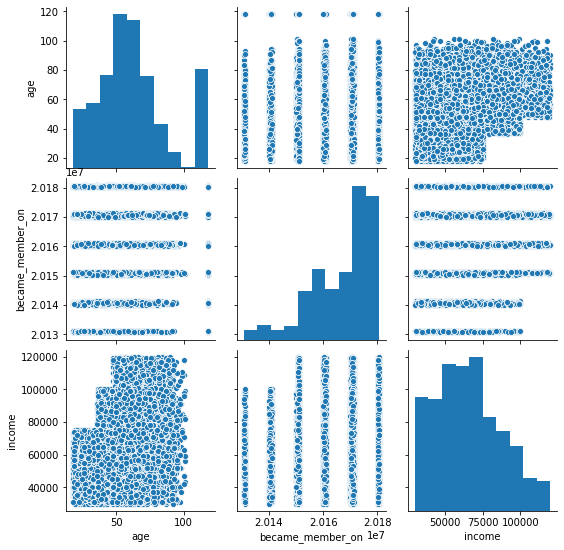

In [431]:
import seaborn 
ax = seaborn.pairplot(profile) ; 
# Plot pairwise relationships profile dataset.

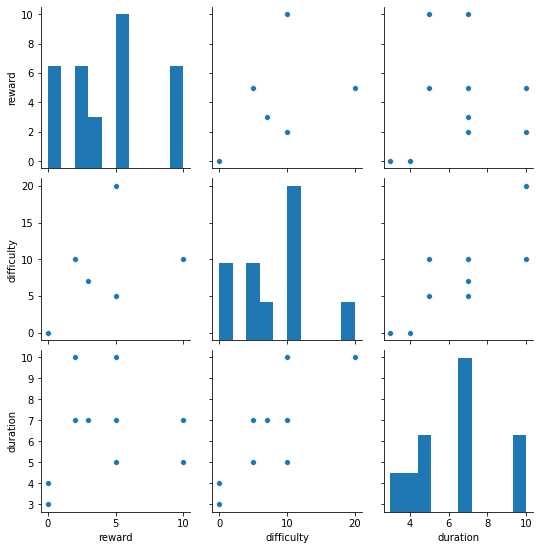

In [432]:
seaborn.pairplot(portfolio) ;
# Plot pairwise relationships portfolio dataset.

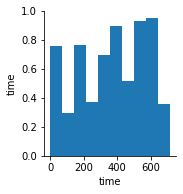

In [433]:
seaborn.pairplot(transcript) ; 
# Plot pairwise relationships transcript dataset.

In [3]:
portfolio.head(25) # get the first 25 elements 

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
portfolio.shape # get the dimensions of dataset

(10, 6)

In [5]:
portfolio.reward.unique() # check for unique rewards values

array([10,  0,  5,  3,  2])

In [6]:
profile.head(10) #get the first 10 enteries of datasets

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


It's noted that there's Nan values in the dataset that need further processing and cleaning 

In [7]:
profile.shape #get the dimensions of the dataset  

(17000, 5)

In [8]:
profile.isna().sum()  #Check the number of Nan values 

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

Looks like we have alot of nan values (2175) at income and gender features , that's interesting cause both columns have the same number of nan values 

In [9]:
Nan_gender_indexes =profile[profile.gender.isnull()]\
.index.tolist() # create a list with indexes of nan gender values 
Nan_income_indexes =profile[profile.income.isnull()]\
.index.tolist()# create a list with indexes of nan income values 

In [10]:
print (len (Nan_gender_indexes),len (Nan_income_indexes)) 
#print the length of Nan_gender and Nan_income lists

2175 2175


The next step is to get the intersection beteween the two lists to see if they have any enteries in common 

In [11]:
len (np.intersect1d(Nan_gender_indexes , Nan_income_indexes)) #print the number of indexes that appear 
                                            #in both Nan_gender and Nan_income

2175

Both Nan_gender and Nan_income appears in the same rows , let's do further data inspection 

In [12]:
profile.iloc[Nan_gender_indexes] #Show dataset with Nan gender 

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


In [13]:
print (profile.iloc[Nan_gender_indexes].gender.unique() 
       , profile.iloc[Nan_gender_indexes].income.unique())
#print all values appeared at gender and income in given indexes 

[None] [nan]


In [14]:
profile.iloc[Nan_gender_indexes].age.unique()
# get diiferent age values in  dataset 

array([118])

In [15]:
profile.iloc[Nan_gender_indexes].groupby('age').count() 
# group dataset by age and apply count function

,gender,id,became_member_on,income
age,,,,
118,0,2175,2175,0


#### From above we can summerize our findings  that all rows which have Nan income also  is the same rows with Nan gender is also  the same rows with age = 118  (which is appears to be wrong age ) : so I will dismiss this rows and drop them as they don't carry any useful info 

In [16]:
profile.dropna(inplace = True) #drop rows with Nan values 
profile.isna().sum() # Check if rows is deleted

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

Note : The cell above can be considered as more of data cleaning process than data exploration , but since it's simple I decided to execute it in this section 

In [17]:
pd.DataFrame(profile.age.value_counts().sort_values(ascending=False)).head(10)
# create Dataframe for the top 10 most common ages in dataset

,age
58,408
53,372
51,363
59,359
54,359
57,353
52,351
55,350
56,342
63,338


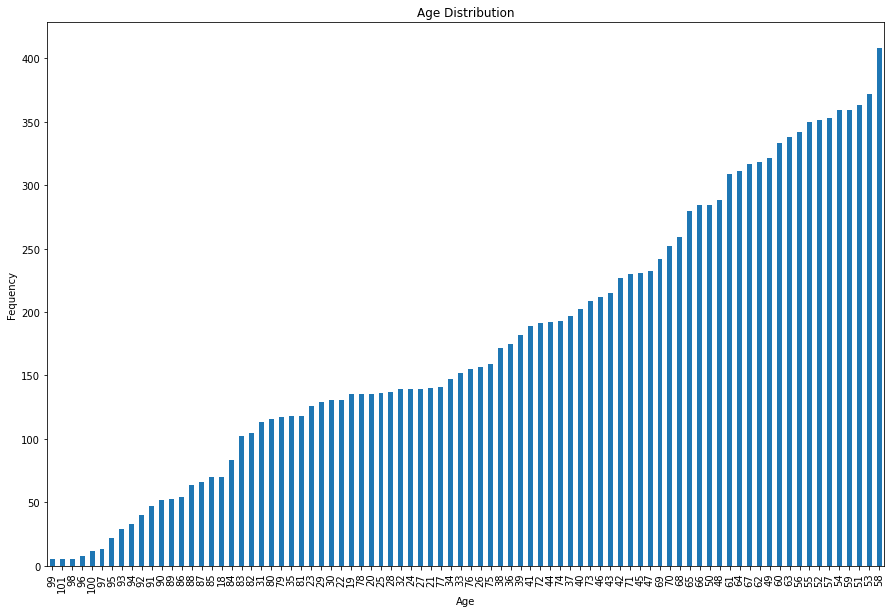

In [18]:
# Create bar chart for ages distribution 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10) # Resize the plot to be clearly visable 
ax = profile.age.value_counts().sort_values(ascending=True)\
.plot(kind = "bar") ;#plot bar chart of the ages 
ax.set_xlabel("Age") ; # add x-axis label 
ax.set_ylabel("Fequency") ; #add y-axis label
ax.set_title("Age Distribution"); # add title to the plot 


It is noted that the graph above is very large and might be disturbing in some way , so I will us histogram to offer better and cleaner  way to graph the data

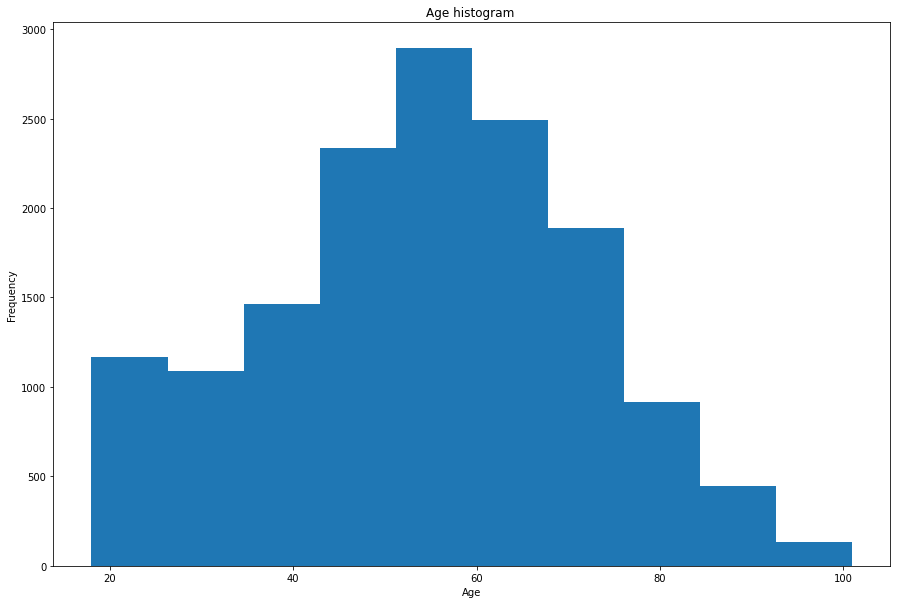

In [19]:
# Create Histogram
plt.hist(profile.age,bins=10); #create histogram and set bins to 10
plt.xlabel("Age"); # set x-axis label
plt.ylabel("Frequency"); #set y-axis label
plt.title("Age histogram "); #set title for plot

In [20]:
pd.DataFrame(profile.gender.value_counts().sort_values(ascending=False)).head(10)
# create Dataframe for the gender counts 

,gender
M,8484
F,6129
O,212


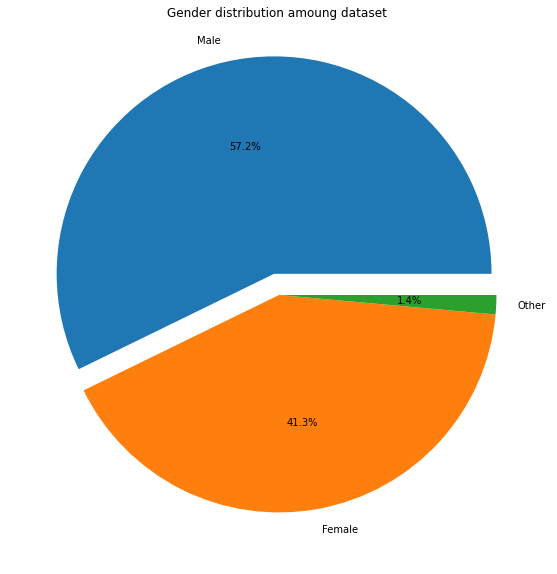

In [435]:
# Make a pie chart plot for gender distribution amoung dataset 
plt.rcParams["figure.figsize"] = (15,10)
plt.pie(x= profile.gender.value_counts().sort_values(ascending=False) ,
        labels= ["Male" , "Female" , "Other"] , 
        explode=(0.1, 0, 0)  , autopct='%1.1f%%') ; 
plt.title("Gender distribution amoung dataset ");

From above pie loos like males have the largest % by nearly 57% of the profiles , In the second place we have females with a % of 41,3% and lastly others with 1.4% 

In [22]:
transcript.shape #get dimensions of dataset

(306534, 4)

In [23]:
transcript.head() #show first five enteries 

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [24]:
#rename column 
transcript = transcript.rename(columns = {'person': 'id'})

In [25]:
transcript #show dataset

,id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


## <font color = grey> Data Cleaning

Since transcript is considered customers actions data and profile contains customer features , we can merge them to have better insights of the data

In [26]:
transcript_profile_df = pd.merge(transcript, profile, on='id')
#merge the two datasets on id feature

In [27]:
transcript_profile_df.groupby("id").count() #group by id and count occurrences 

,event,value,time,gender,age,became_member_on,income
id,,,,,,,
0009655768c64bdeb2e877511632db8f,20,20,20,20,20,20,20
0011e0d4e6b944f998e987f904e8c1e5,18,18,18,18,18,18,18
0020c2b971eb4e9188eac86d93036a77,19,19,19,19,19,19,19
0020ccbbb6d84e358d3414a3ff76cffd,23,23,23,23,23,23,23
003d66b6608740288d6cc97a6903f4f0,30,30,30,30,30,30,30
...,...,...,...,...,...,...,...
fff3ba4757bd42088c044ca26d73817a,23,23,23,23,23,23,23
fff7576017104bcc8677a8d63322b5e1,18,18,18,18,18,18,18
fff8957ea8b240a6b5e634b6ee8eafcf,10,10,10,10,10,10,10


In [28]:
# Create array containing the offer id's for every offer in the dataset
offers_ids =[] #create empty list
for value in transcript_profile_df[transcript_profile_df.event.str.contains("offer")].value : 
# for every value in value column if event column
#conatins 'offer' 
    offers_ids.append(list(value.values())[0]) 
    #append value of dict to offer_keys 
len(np.unique(np.array(offers_ids))) 
# get unique offer ids in dataset 


10

As predicted we have ten different offer ids like we have in the portfolio dataset

In [29]:
transcript_profile_df["offer_id"] = np.NAN #set initally all rows by Nan
transcript_profile_df.loc[transcript_profile_df.event.str.contains("offer"), 'offer_id' ]= offers_ids 
# set offer ids column with offer ids from value column 

In [30]:
transcript_profile_df

,id,event,value,time,gender,age,became_member_on,income,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,F,75,20170509,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,F,75,20170509,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132,F,75,20170509,100000.0,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,F,75,20170509,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144,F,75,20170509,100000.0,NaN
...,...,...,...,...,...,...,...,...,...
272757,9fcbff4f8d7241faa4ab8a9d19c8a812,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504,M,47,20171013,94000.0,3f207df678b143eea3cee63160fa8bed
272758,9fcbff4f8d7241faa4ab8a9d19c8a812,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,M,47,20171013,94000.0,4d5c57ea9a6940dd891ad53e9dbe8da0
272759,9fcbff4f8d7241faa4ab8a9d19c8a812,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,M,47,20171013,94000.0,4d5c57ea9a6940dd891ad53e9dbe8da0
272760,3045af4e98794a04a5542d3eac939b1f,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,F,58,20161020,78000.0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [31]:
# get transcript_profile_df offer_id column 
# unique values length
len(transcript_profile_df.offer_id.unique()) 

11

In [32]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


It is 11 as predicted as we have 10 different offer_ids + Nan 

In [33]:
# Rename columns 
portfolio.rename(columns = {"id" : "offer_id" , 
                           "reward" : 'offer_reward' , 
                           "channels":"offer_channels" , 
                           "difficulty" : "offer_difficulty" , 
                           "duration" : "offer_duration"} , inplace =True)

In [34]:
portfolio

,offer_reward,offer_channels,offer_difficulty,offer_duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


**Recap previous multiple cells :** 
<br>
In past multiple cells I created an offer_id column in transcript_profile merged dataframe
<br>
I also renamed some columns in portflio dataset to give more clear description that this data is related to offers
<br>
This process serves the next part which is merging together the three databases on offer id column 

In [35]:
# Create All_combined_datasets which is all three datasets
# merged together
All_combined_datasets = pd.merge(transcript_profile_df ,portfolio, on= "offer_id"  , how = "left")

In [36]:
# Get Idea how much a user id appears in the 
# newly merged dataset
All_combined_datasets.groupby("id").count()

,event,value,time,gender,age,became_member_on,income,offer_id,offer_reward,offer_channels,offer_difficulty,offer_duration,offer_type
id,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,20,20,20,20,20,20,20,12,12,12,12,12,12
0011e0d4e6b944f998e987f904e8c1e5,18,18,18,18,18,18,18,13,13,13,13,13,13
0020c2b971eb4e9188eac86d93036a77,19,19,19,19,19,19,19,11,11,11,11,11,11
0020ccbbb6d84e358d3414a3ff76cffd,23,23,23,23,23,23,23,11,11,11,11,11,11
003d66b6608740288d6cc97a6903f4f0,30,30,30,30,30,30,30,12,12,12,12,12,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff3ba4757bd42088c044ca26d73817a,23,23,23,23,23,23,23,12,12,12,12,12,12
fff7576017104bcc8677a8d63322b5e1,18,18,18,18,18,18,18,12,12,12,12,12,12
fff8957ea8b240a6b5e634b6ee8eafcf,10,10,10,10,10,10,10,5,5,5,5,5,5


In [37]:
# Get the number of occurences of different events 
All_combined_datasets.groupby("event").count().id

event
offer completed     32444
offer received      66501
offer viewed        49860
transaction        123957
Name: id, dtype: int64

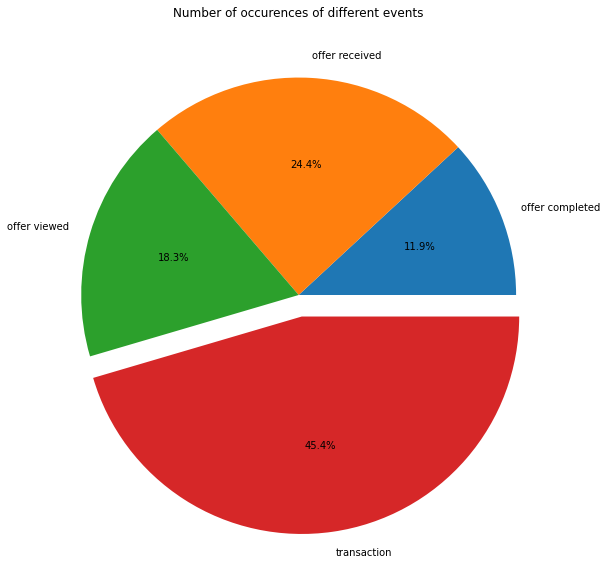

In [38]:
# plot the number of occurences of different events 
# By using piechart
plt.pie(x= All_combined_datasets.groupby("event").count().id ,  labels = 
        ['offer completed' ,'offer received' ,  'offer viewed' ,'transaction']  ,
        explode=(0, 0, 0,0.1)  , autopct='%1.1f%%');
plt.title("Number of occurences of different events");

In [39]:
# Get how much each one of the 10 offers appear
All_combined_datasets.groupby('offer_id').count()

,id,event,value,time,gender,age,became_member_on,income,offer_reward,offer_channels,offer_difficulty,offer_duration,offer_type
offer_id,,,,,,,,,,,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,12327,12327,12327,12327,12327,12327,12327,12327,12327,12327,12327,12327,12327
2298d6c36e964ae4a3e7e9706d1fb8c2,17920,17920,17920,17920,17920,17920,17920,17920,17920,17920,17920,17920,17920
2906b810c7d4411798c6938adc9daaa5,14002,14002,14002,14002,14002,14002,14002,14002,14002,14002,14002,14002,14002
3f207df678b143eea3cee63160fa8bed,10144,10144,10144,10144,10144,10144,10144,10144,10144,10144,10144,10144,10144
4d5c57ea9a6940dd891ad53e9dbe8da0,16232,16232,16232,16232,16232,16232,16232,16232,16232,16232,16232,16232,16232
5a8bc65990b245e5a138643cd4eb9837,12516,12516,12516,12516,12516,12516,12516,12516,12516,12516,12516,12516,12516
9b98b8c7a33c4b65b9aebfe6a799e6d9,14372,14372,14372,14372,14372,14372,14372,14372,14372,14372,14372,14372,14372
ae264e3637204a6fb9bb56bc8210ddfd,16241,16241,16241,16241,16241,16241,16241,16241,16241,16241,16241,16241,16241
f19421c1d4aa40978ebb69ca19b0e20d,16989,16989,16989,16989,16989,16989,16989,16989,16989,16989,16989,16989,16989


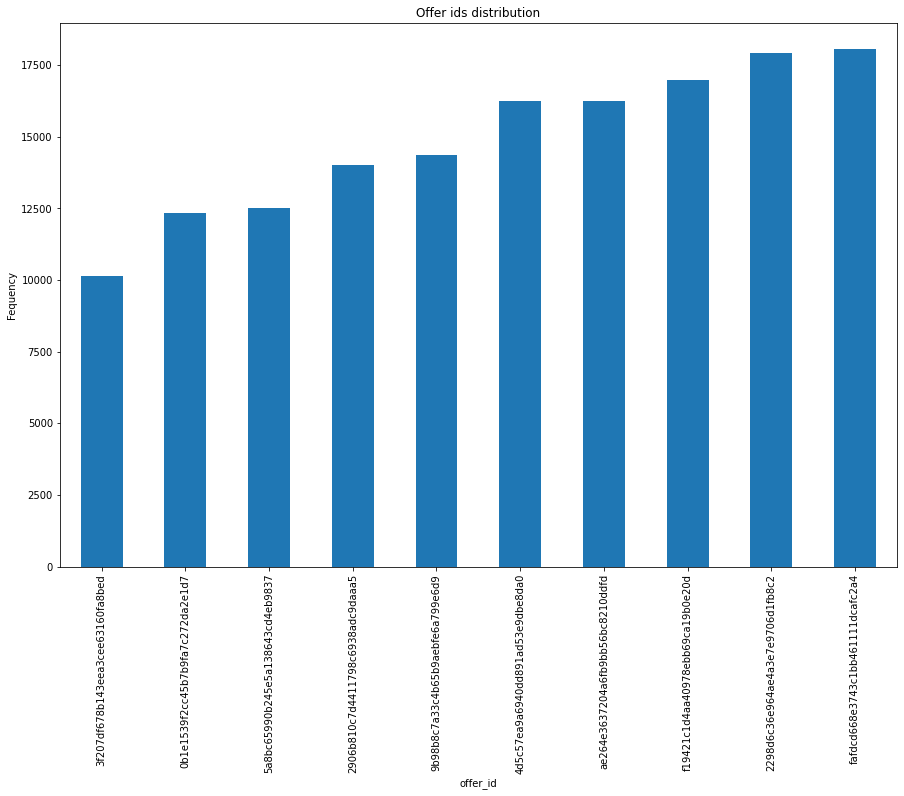

In [40]:
#plot how much each one of the 10 offers appear by using bar chart
ax = All_combined_datasets.groupby('offer_id').count().id.sort_values(ascending=True).plot(kind="bar") ;
#create the bar chart
ax.set_ylabel("Fequency") ; #add y-axis label
ax.set_title("Offer ids distribution");#add plot title

In [41]:
# Get How much each of the 10 offers is completed
All_combined_datasets.query("event=='offer completed'").groupby('offer_id').count()

,id,event,value,time,gender,age,became_member_on,income,offer_reward,offer_channels,offer_difficulty,offer_duration,offer_type
offer_id,,,,,,,,,,,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,3386,3386,3386,3386,3386,3386,3386,3386,3386,3386,3386,3386,3386
2298d6c36e964ae4a3e7e9706d1fb8c2,4886,4886,4886,4886,4886,4886,4886,4886,4886,4886,4886,4886,4886
2906b810c7d4411798c6938adc9daaa5,3911,3911,3911,3911,3911,3911,3911,3911,3911,3911,3911,3911,3911
4d5c57ea9a6940dd891ad53e9dbe8da0,3310,3310,3310,3310,3310,3310,3310,3310,3310,3310,3310,3310,3310
9b98b8c7a33c4b65b9aebfe6a799e6d9,4188,4188,4188,4188,4188,4188,4188,4188,4188,4188,4188,4188,4188
ae264e3637204a6fb9bb56bc8210ddfd,3657,3657,3657,3657,3657,3657,3657,3657,3657,3657,3657,3657,3657
f19421c1d4aa40978ebb69ca19b0e20d,4103,4103,4103,4103,4103,4103,4103,4103,4103,4103,4103,4103,4103
fafdcd668e3743c1bb461111dcafc2a4,5003,5003,5003,5003,5003,5003,5003,5003,5003,5003,5003,5003,5003


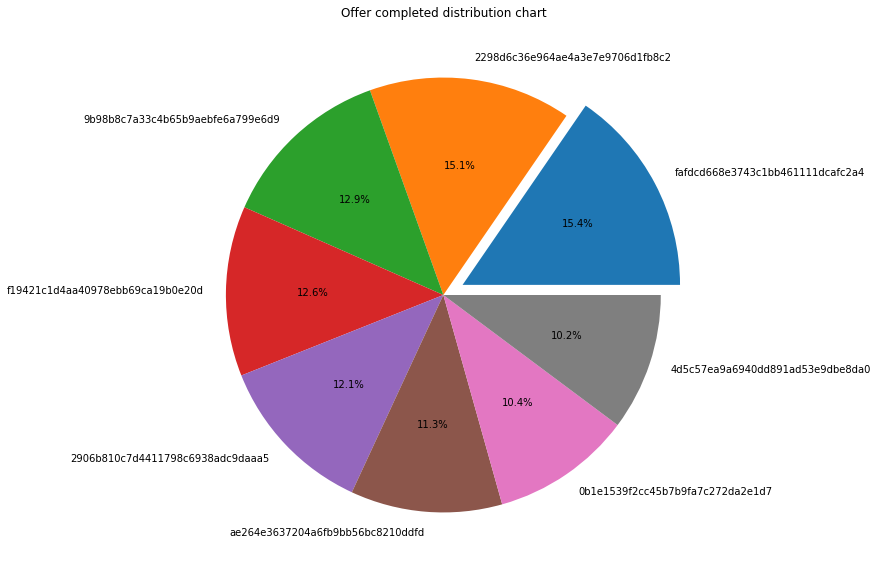

In [42]:
# plot how much each of the 10 offers is completed 
# by using pie chart
plt.pie(x = All_combined_datasets.query("event=='offer completed'").groupby('offer_id')\
        .count().id.sort_values(ascending=False)
        , labels = All_combined_datasets.query("event=='offer completed'")\
        .groupby('offer_id').count().id.sort_values(ascending=False).keys()
        ,explode=(0.1, 0, 0,0,0,0,0,0)  , autopct='%1.1f%%');
plt.title("Offer completed distribution chart") ;

In [43]:
# Get the offer types of offers completed 
All_combined_datasets.query("event=='offer completed'").groupby('offer_type').count()

,id,event,value,time,gender,age,became_member_on,income,offer_id,offer_reward,offer_channels,offer_difficulty,offer_duration
offer_type,,,,,,,,,,,,,
bogo,15258,15258,15258,15258,15258,15258,15258,15258,15258,15258,15258,15258,15258
discount,17186,17186,17186,17186,17186,17186,17186,17186,17186,17186,17186,17186,17186


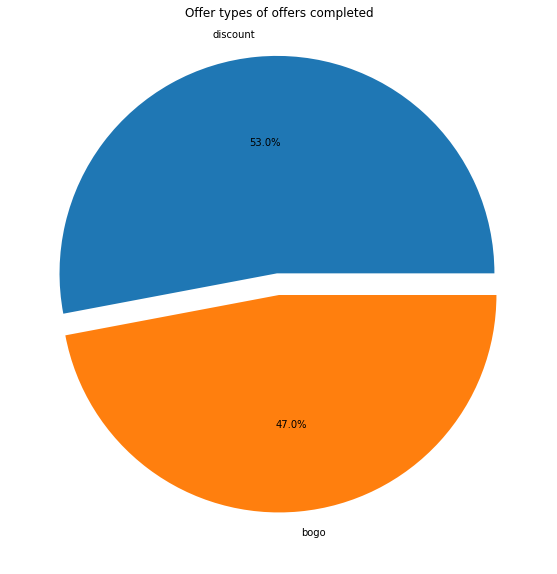

In [44]:
# plot the offer types of offers completed 
plt.pie(x = All_combined_datasets.query("event=='offer completed'").groupby('offer_type')\
        .count().id.sort_values(ascending=False)
        , labels = All_combined_datasets.query("event=='offer completed'")\
        .groupby('offer_type').count().id.sort_values(ascending=False).keys()
        ,explode=(0.1, 0)  , autopct='%1.1f%%');
plt.title("Offer types of offers completed") ;# set plot title

In [45]:
# Get gender distribution for offers completed
All_combined_datasets.query("event=='offer completed'").groupby('gender').count()

,id,event,value,time,age,became_member_on,income,offer_id,offer_reward,offer_channels,offer_difficulty,offer_duration,offer_type
gender,,,,,,,,,,,,,
F,15477,15477,15477,15477,15477,15477,15477,15477,15477,15477,15477,15477,15477
M,16466,16466,16466,16466,16466,16466,16466,16466,16466,16466,16466,16466,16466
O,501,501,501,501,501,501,501,501,501,501,501,501,501


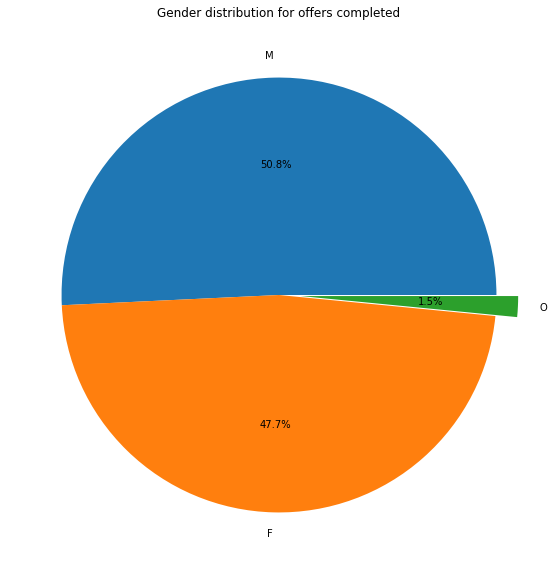

In [46]:
# Plot gender distribution for offers completed
plt.pie(x = All_combined_datasets.query("event=='offer completed'").groupby('gender')\
        .count().id.sort_values(ascending=False)
        , labels = All_combined_datasets.query("event=='offer completed'")\
        .groupby('gender').count().id.sort_values(ascending=False).keys()
        ,explode=(0, 0 , 0.1)  , autopct='%1.1f%%');
plt.title('Gender distribution for offers completed');

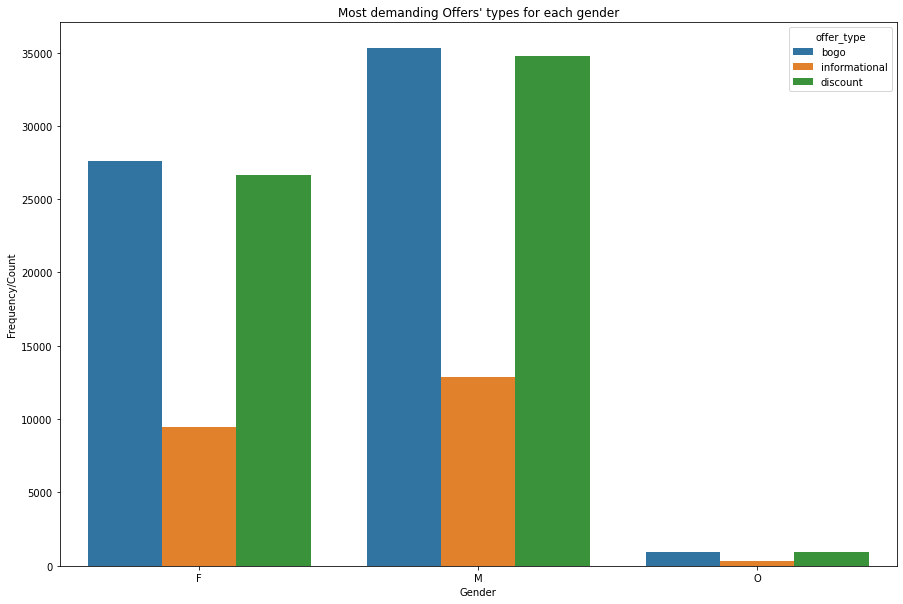

In [47]:
# Create number/frequency of offer types for each of the genders
import seaborn as sns
sns.countplot(x="gender", hue="offer_type", data=All_combined_datasets) #create plot
plt.title("Most demanding Offers' types for each gender") # set title
plt.ylabel('Frequency/Count') # set label for y-axis label 
plt.xlabel('Gender') # set label for x-axis label 
plt.show(); # show plot

## <font color = "grey">Prepare Data for modeling

In [48]:
All_combined_datasets.head(20) # show the first 20 enteries

,id,event,value,time,gender,age,became_member_on,income,offer_id,offer_reward,offer_channels,offer_difficulty,offer_duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,F,75,20170509,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,F,75,20170509,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132,F,75,20170509,100000.0,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,F,75,20170509,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144,F,75,20170509,100000.0,NaN,NaN,NaN,NaN,NaN,NaN
5,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,F,75,20170509,100000.0,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,3.0,informational
6,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216,F,75,20170509,100000.0,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,3.0,informational
7,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222,F,75,20170509,100000.0,NaN,NaN,NaN,NaN,NaN,NaN
8,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240,F,75,20170509,100000.0,NaN,NaN,NaN,NaN,NaN,NaN
9,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378,F,75,20170509,100000.0,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# Get only the year out of the date
date_data = []
for date in All_combined_datasets.became_member_on:
    date_data.append(str(date)[:4])

In [50]:
np.unique(np.array(date_data)) 
# get unique values in date_data list

array(['2013', '2014', '2015', '2016', '2017', '2018'], dtype='<U4')

Looks like all users become members on the interval from 2013-2018

In [51]:
# set became_member_on column to the new years only format
All_combined_datasets.became_member_on = date_data

In [52]:
All_combined_datasets.head() # show the first 5 enteries

,id,event,value,time,gender,age,became_member_on,income,offer_id,offer_reward,offer_channels,offer_difficulty,offer_duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,F,75,2017,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,F,75,2017,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132,F,75,2017,100000.0,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,F,75,2017,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144,F,75,2017,100000.0,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
#Get unique values for age 
All_combined_datasets.age.unique()

array([ 75,  68,  65,  58,  61,  62,  64,  78,  88,  42,  56,  59,  22,
        96,  40,  69,  26,  20,  45,  54,  39,  79,  66,  48,  37,  73,
        44,  63,  27,  67,  76,  53,  74,  38,  70,  49,  50,  90,  19,
        72,  52,  55,  57,  18,  51,  71,  83,  29,  25,  77,  47,  60,
        36,  46,  81,  24,  34,  89,  41,  30,  32,  85,  23, 100,  43,
        82,  28,  35,  80,  84,  87,  86,  94,  33,  95,  31,  93,  92,
        21,  98,  91, 101,  97,  99])

In [54]:
####
#Function take age series and return 6 
#different ages categories instead of ages
####
def age (ages) : 
    new_age = []
    for age in ages:
        if age < 30 : 
            new_age.append("<30")
        elif 30<= age <=39 : 
            new_age.append("30s")
        elif 40<= age <=49 : 
            new_age.append("40s")
        elif 50<= age <=59 : 
            new_age.append("50s")
        elif 60<= age <=69 : 
            new_age.append("60s")
        else :
            new_age.append(">=70")
    return new_age
            
            
            

In [55]:
# set ages to 6 categories
All_combined_datasets.age = age(All_combined_datasets.age)

In [56]:
# get uniue values for age
All_combined_datasets.age.unique()

array(['>=70', '60s', '50s', '40s', '<30', '30s'], dtype=object)

In [57]:
All_combined_datasets.head() # Check if changes took place

,id,event,value,time,gender,age,became_member_on,income,offer_id,offer_reward,offer_channels,offer_difficulty,offer_duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,F,>=70,2017,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,F,>=70,2017,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132,F,>=70,2017,100000.0,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,F,>=70,2017,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144,F,>=70,2017,100000.0,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
# get value counts for the new age col 
All_combined_datasets.age.value_counts()

50s     63767
60s     53926
>=70    51418
40s     42480
<30     30941
30s     30230
Name: age, dtype: int64

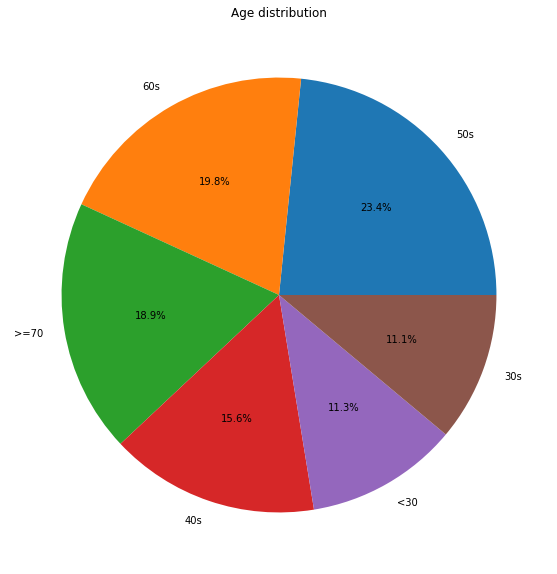

In [59]:
# plot the age distribution 
plt.pie(All_combined_datasets.age.value_counts().sort_values(ascending=False) , 
labels = All_combined_datasets.age.value_counts().keys(), autopct='%1.1f%%'); # create pie plot
plt.title("Age distribution") ; # set title for the plot 

Looks like people over 30 years are very dominant in this datasets by nearly 77.6% of the data  

In [60]:
All_combined_datasets.head(25) # print the first 25 enteries

,id,event,value,time,gender,age,became_member_on,income,offer_id,offer_reward,offer_channels,offer_difficulty,offer_duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,F,>=70,2017,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,F,>=70,2017,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132,F,>=70,2017,100000.0,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,F,>=70,2017,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144,F,>=70,2017,100000.0,NaN,NaN,NaN,NaN,NaN,NaN
5,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,F,>=70,2017,100000.0,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,3.0,informational
6,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216,F,>=70,2017,100000.0,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,3.0,informational
7,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222,F,>=70,2017,100000.0,NaN,NaN,NaN,NaN,NaN,NaN
8,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240,F,>=70,2017,100000.0,NaN,NaN,NaN,NaN,NaN,NaN
9,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378,F,>=70,2017,100000.0,NaN,NaN,NaN,NaN,NaN,NaN


### Rccap

From above steps we have solid knowledge of our data , previously we combined the three datasets to see the bigger image , however the
**All_combined_datasets** 
is still not to be considered to be entered to machine learning model  ,one of the reasons for that is that every single user ("id") is repeated multiple times in different rows to inidcate his actions and transactions 

### Next Step : 
I will create another dataframe that shows how much user complete , view and  recieve offers and what how many offers of each offer types he completed 


In [61]:
Model_dataframe = pd.DataFrame(All_combined_datasets.query("event =='offer received'")\
                               .groupby('id').count().event)
# count offer recieved for each user id and create an intial df with it 
Model_dataframe.rename(columns = {"event":"Total Offers recieved"} , inplace = True)
# Rename the event col with  representative name 
Model_dataframe["Total Offers viewed"] = All_combined_datasets\
.query("event =='offer viewed'").groupby('id').count().event
# count offer viewed for each user id 
Model_dataframe["Total Offers completed"] = All_combined_datasets\
.query("event =='offer completed'").groupby('id').count().event
# count offer completed for each user id 


In [62]:
Model_dataframe # View Model_dataframe

,Total Offers recieved,Total Offers viewed,Total Offers completed
id,,,
0009655768c64bdeb2e877511632db8f,5,4.0,3.0
0011e0d4e6b944f998e987f904e8c1e5,5,5.0,3.0
0020c2b971eb4e9188eac86d93036a77,5,3.0,3.0
0020ccbbb6d84e358d3414a3ff76cffd,4,4.0,3.0
003d66b6608740288d6cc97a6903f4f0,5,4.0,3.0
...,...,...,...
fff3ba4757bd42088c044ca26d73817a,6,3.0,3.0
fff7576017104bcc8677a8d63322b5e1,5,4.0,3.0
fff8957ea8b240a6b5e634b6ee8eafcf,3,2.0,NaN


In [63]:
Model_dataframe["bogo received"]=All_combined_datasets\
.query("event =='offer received' and offer_type == 'bogo'").groupby('id').count().event  
# count the bogo received for each user 
Model_dataframe["discount received"]= All_combined_datasets\
.query("event =='offer received' and offer_type == 'discount'").groupby('id').count().event
# count the discount received for each user 
Model_dataframe["informational received"] = All_combined_datasets\
.query("event =='offer received' and offer_type == 'informational'").groupby('id').count().event
# count the informational received for each user 

In [64]:
Model_dataframe["bogo viewed"]=All_combined_datasets\
.query("event =='offer viewed' and offer_type == 'bogo'").groupby('id').count().event
# count the bogo viewed for each user
Model_dataframe["discount viewed"]= All_combined_datasets\
.query("event =='offer viewed' and offer_type == 'discount'").groupby('id').count().event
# count the discount viewed for each user 
Model_dataframe["informational viewed"] = All_combined_datasets\
.query("event =='offer viewed' and offer_type == 'informational'").groupby('id').count().event
# count the informational viewed for each user 

In [65]:
Model_dataframe["bogo completed"]=All_combined_datasets\
.query("event =='offer completed' and offer_type == 'bogo'").groupby('id').count().event
# count the bogo viewed for each user
Model_dataframe["discount completed"]= All_combined_datasets\
.query("event =='offer completed' and offer_type == 'discount'").groupby('id').count().event
# count the discount completed for each user
Model_dataframe["informational completed"] = All_combined_datasets\
.query("event =='offer completed' and offer_type == 'informational'").groupby('id').count().event
# count the informational completed for each user

In [66]:
Model_dataframe # display Model_dataframe

,Total Offers recieved,Total Offers viewed,Total Offers completed,bogo received,discount received,informational received,bogo viewed,discount viewed,informational viewed,bogo completed,discount completed,informational completed
id,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,5,4.0,3.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,5,5.0,3.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,NaN
0020c2b971eb4e9188eac86d93036a77,5,3.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,NaN
0020ccbbb6d84e358d3414a3ff76cffd,4,4.0,3.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,NaN
003d66b6608740288d6cc97a6903f4f0,5,4.0,3.0,NaN,3.0,2.0,NaN,2.0,2.0,NaN,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
fff3ba4757bd42088c044ca26d73817a,6,3.0,3.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,NaN
fff7576017104bcc8677a8d63322b5e1,5,4.0,3.0,3.0,2.0,NaN,2.0,2.0,NaN,1.0,2.0,NaN
fff8957ea8b240a6b5e634b6ee8eafcf,3,2.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN


In [67]:
Model_dataframe = Model_dataframe.merge(profile.set_index("id"), on = "id")
# Merge profile dataset with existing Model_dataframe

In [68]:
Model_dataframe 
# display Model_dataframe to see if changes took place

,Total Offers recieved,Total Offers viewed,Total Offers completed,bogo received,discount received,informational received,bogo viewed,discount viewed,informational viewed,bogo completed,discount completed,informational completed,gender,age,became_member_on,income
id,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,5,4.0,3.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,NaN,M,33,20170421,72000.0
0011e0d4e6b944f998e987f904e8c1e5,5,5.0,3.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,NaN,O,40,20180109,57000.0
0020c2b971eb4e9188eac86d93036a77,5,3.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,NaN,F,59,20160304,90000.0
0020ccbbb6d84e358d3414a3ff76cffd,4,4.0,3.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,NaN,F,24,20161111,60000.0
003d66b6608740288d6cc97a6903f4f0,5,4.0,3.0,NaN,3.0,2.0,NaN,2.0,2.0,NaN,3.0,NaN,F,26,20170621,73000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff3ba4757bd42088c044ca26d73817a,6,3.0,3.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,NaN,F,69,20150920,83000.0
fff7576017104bcc8677a8d63322b5e1,5,4.0,3.0,3.0,2.0,NaN,2.0,2.0,NaN,1.0,2.0,NaN,M,71,20171031,73000.0
fff8957ea8b240a6b5e634b6ee8eafcf,3,2.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,M,71,20180218,56000.0


In [69]:
# Convert offer_channels from list to string 
All_combined_datasets.offer_channels = All_combined_datasets.offer_channels.astype(str)

In [70]:
type(All_combined_datasets.offer_channels[0]) 
# check the type of column to see if changes took place 

str

I Converted offer_channels from list to string to be able to use label encoder to transfer it from categorical -string- to numerical to make it easier and more suitable to use in ML process 

In [71]:
from sklearn.preprocessing import LabelEncoder 
labelencoder= LabelEncoder() #initializing an object of class LabelEncoder
All_combined_datasets.offer_channels = labelencoder.fit_transform(All_combined_datasets.offer_channels) 
#fitting and transforming the desired categorical column.

In [72]:
len(All_combined_datasets.offer_channels.unique())
# get length of unique values of offer channels column 

5

### Recap 
I created model dataframe having for each user ("id") how much offers he recieved , viewed and completed and how many of those offers are related to different kind of offers(bogo , discount) 
### Next step 
To create a machine learning algorithm to detect which offer and channel is best fit to our end user , we need two important things to be clear in our final dataset that the model will be trained on : 
<br>
1- Which offer type does he best response to ? 
<br>
2- which channel did is best to this user ? 
<br>
Having this data is necessary to create and train our models , the upcoming step is detecting whihc channel is best for each user 

In [73]:
offer_channels_pd = pd.DataFrame(All_combined_datasets.query("event =='offer completed'")\
                                 .groupby("id").offer_channels.value_counts())
# Create offer_channels_pd which contain user id and completed offer number 
#for each othe channels 

In [74]:
offer_channels_pd

offer_channels
id                               offer_channels                
0009655768c64bdeb2e877511632db8f 1                            2
                                 2                            1
0011e0d4e6b944f998e987f904e8c1e5 1                            1
                                 2                            1
                                 3                            1
...                                                         ...
fffad4f4828548d1b5583907f2e9906b 1                            2
                                 2                            1
ffff82501cea40309d5fdd7edcca4a07 2                            4
                                 1                            1
                                 3                            1

[22091 rows x 1 columns]

In [75]:
 offer_channels_pd.rename(columns = {"offer_channels": "completed_channel_offer"},inplace = True  )
    #rename col offer_channels to completed_channel_offer to be more representative 

In [76]:
offer_channels_pd.reset_index(inplace = True) #Reset index 
offer_channels_pd.set_index("offer_channels" , inplace = True) # set index to offer channels 

In [77]:
offer_channels_pd # Display the dataframe 

,id,completed_channel_offer
offer_channels,,
1,0009655768c64bdeb2e877511632db8f,2
2,0009655768c64bdeb2e877511632db8f,1
1,0011e0d4e6b944f998e987f904e8c1e5,1
2,0011e0d4e6b944f998e987f904e8c1e5,1
3,0011e0d4e6b944f998e987f904e8c1e5,1
...,...,...
1,fffad4f4828548d1b5583907f2e9906b,2
2,fffad4f4828548d1b5583907f2e9906b,1
2,ffff82501cea40309d5fdd7edcca4a07,4


In [78]:
offer_channels_pd["best_channel"] = [0]*offer_channels_pd.shape[0] 
# set intially new best channel col to zeros
for Id in offer_channels_pd.id :
    offer_channels_pd.loc[offer_channels_pd.id==Id , "best_channel"]=offer_channels_pd.loc[offer_channels_pd.id == Id].completed_channel_offer.idxmax()
# for each user we will detect which channel was best for him by
#looking at maximum number of offers completed by one channel 

In [79]:
offer_channels_pd # Display dataframe to see new best_channel column

,id,completed_channel_offer,best_channel
offer_channels,,,
1,0009655768c64bdeb2e877511632db8f,2,1
2,0009655768c64bdeb2e877511632db8f,1,1
1,0011e0d4e6b944f998e987f904e8c1e5,1,1
2,0011e0d4e6b944f998e987f904e8c1e5,1,1
3,0011e0d4e6b944f998e987f904e8c1e5,1,1
...,...,...,...
1,fffad4f4828548d1b5583907f2e9906b,2,1
2,fffad4f4828548d1b5583907f2e9906b,1,1
2,ffff82501cea40309d5fdd7edcca4a07,4,2


In [80]:
offer_channels_pd.reset_index(inplace = True) # reset the index
offer_channels_pd.set_index("id" , inplace = True) # set id as the index 

In [81]:
offer_channels_pd # Display Dataframe to see if changes took place 

,offer_channels,completed_channel_offer,best_channel
id,,,
0009655768c64bdeb2e877511632db8f,1,2,1
0009655768c64bdeb2e877511632db8f,2,1,1
0011e0d4e6b944f998e987f904e8c1e5,1,1,1
0011e0d4e6b944f998e987f904e8c1e5,2,1,1
0011e0d4e6b944f998e987f904e8c1e5,3,1,1
...,...,...,...
fffad4f4828548d1b5583907f2e9906b,1,2,1
fffad4f4828548d1b5583907f2e9906b,2,1,1
ffff82501cea40309d5fdd7edcca4a07,2,4,2


### Recap : 
In the previous steps we created a dataframe which conatins each user and which channels he used and how much offers were completed through each channels , and from that data we treated the channel that has maximium offers completed through it as best channel for that user 
<br>
Note : There's disadvantage of that approach which is that user might complete same number of offers in multiple channel options , so when choosing best channel one of the channels will be choosen as best which is not very true but it's acceptable since both channels were able to get same attention from user 
### Next Step :
We will need one row for each user in which this row conatin his id and his  best channel 

In [82]:
best_channel_df = offer_channels_pd.drop(['offer_channels','completed_channel_offer'] , axis = 1)
# create new dataframe contain user id and best channel for him

In [83]:
best_channel_df # display best_channel_df

,best_channel
id,
0009655768c64bdeb2e877511632db8f,1
0009655768c64bdeb2e877511632db8f,1
0011e0d4e6b944f998e987f904e8c1e5,1
0011e0d4e6b944f998e987f904e8c1e5,1
0011e0d4e6b944f998e987f904e8c1e5,1
...,...
fffad4f4828548d1b5583907f2e9906b,1
fffad4f4828548d1b5583907f2e9906b,1
ffff82501cea40309d5fdd7edcca4a07,2


In [84]:
best_channel_df.reset_index(inplace= True)  # reset index 
best_channel_df.drop_duplicates("id",inplace = True) # drop duplicates based on id columns
best_channel_df.set_index("id",inplace = True) # set index to id again 

In [85]:
best_channel_df  # display best_channel_df to check for changes

,best_channel
id,
0009655768c64bdeb2e877511632db8f,1
0011e0d4e6b944f998e987f904e8c1e5,1
0020c2b971eb4e9188eac86d93036a77,1
0020ccbbb6d84e358d3414a3ff76cffd,1
003d66b6608740288d6cc97a6903f4f0,1
...,...
fff29fb549084123bd046dbc5ceb4faa,1
fff3ba4757bd42088c044ca26d73817a,2
fff7576017104bcc8677a8d63322b5e1,1


### Now it is noted that we have the best channel for each one of our users , the next step is to get the best offer for each user 

In [86]:
Model_dataframe # show our model dataframe

,Total Offers recieved,Total Offers viewed,Total Offers completed,bogo received,discount received,informational received,bogo viewed,discount viewed,informational viewed,bogo completed,discount completed,informational completed,gender,age,became_member_on,income
id,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,5,4.0,3.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,NaN,M,33,20170421,72000.0
0011e0d4e6b944f998e987f904e8c1e5,5,5.0,3.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,NaN,O,40,20180109,57000.0
0020c2b971eb4e9188eac86d93036a77,5,3.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,NaN,F,59,20160304,90000.0
0020ccbbb6d84e358d3414a3ff76cffd,4,4.0,3.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,NaN,F,24,20161111,60000.0
003d66b6608740288d6cc97a6903f4f0,5,4.0,3.0,NaN,3.0,2.0,NaN,2.0,2.0,NaN,3.0,NaN,F,26,20170621,73000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff3ba4757bd42088c044ca26d73817a,6,3.0,3.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,NaN,F,69,20150920,83000.0
fff7576017104bcc8677a8d63322b5e1,5,4.0,3.0,3.0,2.0,NaN,2.0,2.0,NaN,1.0,2.0,NaN,M,71,20171031,73000.0
fff8957ea8b240a6b5e634b6ee8eafcf,3,2.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,M,71,20180218,56000.0


In [87]:
Model_dataframe = Model_dataframe.merge(best_channel_df , on="id")
#merge model dataframe with best_channel dataframe on id 

In [88]:
Model_dataframe # display the newly merged dataframe

,Total Offers recieved,Total Offers viewed,Total Offers completed,bogo received,discount received,informational received,bogo viewed,discount viewed,informational viewed,bogo completed,discount completed,informational completed,gender,age,became_member_on,income,best_channel
id,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,5,4.0,3.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,NaN,M,33,20170421,72000.0,1
0011e0d4e6b944f998e987f904e8c1e5,5,5.0,3.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,NaN,O,40,20180109,57000.0,1
0020c2b971eb4e9188eac86d93036a77,5,3.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,NaN,F,59,20160304,90000.0,1
0020ccbbb6d84e358d3414a3ff76cffd,4,4.0,3.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,NaN,F,24,20161111,60000.0,1
003d66b6608740288d6cc97a6903f4f0,5,4.0,3.0,NaN,3.0,2.0,NaN,2.0,2.0,NaN,3.0,NaN,F,26,20170621,73000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff29fb549084123bd046dbc5ceb4faa,6,5.0,6.0,5.0,1.0,NaN,4.0,1.0,NaN,5.0,1.0,NaN,F,59,20170831,93000.0,1
fff3ba4757bd42088c044ca26d73817a,6,3.0,3.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,NaN,F,69,20150920,83000.0,2
fff7576017104bcc8677a8d63322b5e1,5,4.0,3.0,3.0,2.0,NaN,2.0,2.0,NaN,1.0,2.0,NaN,M,71,20171031,73000.0,1


In [89]:
Model_dataframe['informational completed'].unique()
# check for unique values for informational completed column 

array([nan])

since all of the column enteries is nan I can drop it 

In [90]:
Model_dataframe = Model_dataframe.drop('informational completed' , axis = 1)
# drop column 

### Recap : 
In the above cells we created a dataframe to get best channel for each user and merged that with our model dataframe to have one full dataset
### Next step : 
Now we have the best channel for each user , next we need to know which is the best offer for each user
<br>
To do that I will give each of the offers a score , But since one user might recive more offers of one type than others and might view more offers than another i will use the following formula as a step to help remove bias out of data : 

**offer score = offer completed / Total Offers viewed + Total Offers recieved**

In [91]:
dem = (Model_dataframe['Total Offers recieved'] + Model_dataframe['Total Offers viewed'])
# set the denominator value 
Model_dataframe["bogo_score"] = Model_dataframe['bogo completed'] / dem
# create bogo score column

In [92]:
Model_dataframe["discount _score"] = Model_dataframe['discount completed'] / dem
# create discount score column

In [93]:
Model_dataframe # display dataframe to see if changes took place 

,Total Offers recieved,Total Offers viewed,Total Offers completed,bogo received,discount received,informational received,bogo viewed,discount viewed,informational viewed,bogo completed,discount completed,gender,age,became_member_on,income,best_channel,bogo_score,discount _score
id,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,5,4.0,3.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,M,33,20170421,72000.0,1,0.111111,0.222222
0011e0d4e6b944f998e987f904e8c1e5,5,5.0,3.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,O,40,20180109,57000.0,1,0.100000,0.200000
0020c2b971eb4e9188eac86d93036a77,5,3.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,F,59,20160304,90000.0,1,0.125000,0.250000
0020ccbbb6d84e358d3414a3ff76cffd,4,4.0,3.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,F,24,20161111,60000.0,1,0.250000,0.125000
003d66b6608740288d6cc97a6903f4f0,5,4.0,3.0,NaN,3.0,2.0,NaN,2.0,2.0,NaN,3.0,F,26,20170621,73000.0,1,NaN,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff29fb549084123bd046dbc5ceb4faa,6,5.0,6.0,5.0,1.0,NaN,4.0,1.0,NaN,5.0,1.0,F,59,20170831,93000.0,1,0.454545,0.090909
fff3ba4757bd42088c044ca26d73817a,6,3.0,3.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,F,69,20150920,83000.0,2,0.111111,0.222222
fff7576017104bcc8677a8d63322b5e1,5,4.0,3.0,3.0,2.0,NaN,2.0,2.0,NaN,1.0,2.0,M,71,20171031,73000.0,1,0.111111,0.222222


In [94]:
Model_dataframe['best_offer'] =np.where((Model_dataframe['bogo_score'] > Model_dataframe['discount _score'])
                     , "bogo", "discount")
# create best_offer col to indicate which offer scores higher hence is best 

In [95]:
Model_dataframe # display dataframe to see if changes took place 

,Total Offers recieved,Total Offers viewed,Total Offers completed,bogo received,discount received,informational received,bogo viewed,discount viewed,informational viewed,bogo completed,discount completed,gender,age,became_member_on,income,best_channel,bogo_score,discount _score,best_offer
id,,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,5,4.0,3.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,M,33,20170421,72000.0,1,0.111111,0.222222,discount
0011e0d4e6b944f998e987f904e8c1e5,5,5.0,3.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,O,40,20180109,57000.0,1,0.100000,0.200000,discount
0020c2b971eb4e9188eac86d93036a77,5,3.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,F,59,20160304,90000.0,1,0.125000,0.250000,discount
0020ccbbb6d84e358d3414a3ff76cffd,4,4.0,3.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,F,24,20161111,60000.0,1,0.250000,0.125000,bogo
003d66b6608740288d6cc97a6903f4f0,5,4.0,3.0,NaN,3.0,2.0,NaN,2.0,2.0,NaN,3.0,F,26,20170621,73000.0,1,NaN,0.333333,discount
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff29fb549084123bd046dbc5ceb4faa,6,5.0,6.0,5.0,1.0,NaN,4.0,1.0,NaN,5.0,1.0,F,59,20170831,93000.0,1,0.454545,0.090909,bogo
fff3ba4757bd42088c044ca26d73817a,6,3.0,3.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,F,69,20150920,83000.0,2,0.111111,0.222222,discount
fff7576017104bcc8677a8d63322b5e1,5,4.0,3.0,3.0,2.0,NaN,2.0,2.0,NaN,1.0,2.0,M,71,20171031,73000.0,1,0.111111,0.222222,discount


In [96]:
Model_dataframe['best_offer'] =np.where((Model_dataframe['bogo_score'] == Model_dataframe['discount _score'])
                     , "Both", Model_dataframe['best_offer'])
# Check if both scores score the them then best_offer is both 

In [97]:
Model_dataframe # display dataframe to see if changes took place 

,Total Offers recieved,Total Offers viewed,Total Offers completed,bogo received,discount received,informational received,bogo viewed,discount viewed,informational viewed,bogo completed,discount completed,gender,age,became_member_on,income,best_channel,bogo_score,discount _score,best_offer
id,,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,5,4.0,3.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,M,33,20170421,72000.0,1,0.111111,0.222222,discount
0011e0d4e6b944f998e987f904e8c1e5,5,5.0,3.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,O,40,20180109,57000.0,1,0.100000,0.200000,discount
0020c2b971eb4e9188eac86d93036a77,5,3.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,F,59,20160304,90000.0,1,0.125000,0.250000,discount
0020ccbbb6d84e358d3414a3ff76cffd,4,4.0,3.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,F,24,20161111,60000.0,1,0.250000,0.125000,bogo
003d66b6608740288d6cc97a6903f4f0,5,4.0,3.0,NaN,3.0,2.0,NaN,2.0,2.0,NaN,3.0,F,26,20170621,73000.0,1,NaN,0.333333,discount
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff29fb549084123bd046dbc5ceb4faa,6,5.0,6.0,5.0,1.0,NaN,4.0,1.0,NaN,5.0,1.0,F,59,20170831,93000.0,1,0.454545,0.090909,bogo
fff3ba4757bd42088c044ca26d73817a,6,3.0,3.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,F,69,20150920,83000.0,2,0.111111,0.222222,discount
fff7576017104bcc8677a8d63322b5e1,5,4.0,3.0,3.0,2.0,NaN,2.0,2.0,NaN,1.0,2.0,M,71,20171031,73000.0,1,0.111111,0.222222,discount


In [98]:
Model_dataframe.best_offer.unique() # check for unique values for best_offer 

array(['discount', 'bogo', 'Both'], dtype=object)

### Recap : 
In previous cells we were able to decide which offer is the best and previously we were able to decide what's the best channel 
### Next step : 
we combine those two pieces of info to create different combinations of offers , where each user has his best combined score 

In [99]:
Model_dataframe["best_option"] = Model_dataframe.best_channel.astype(str)+Model_dataframe.best_offer
# create best_option col as a combination between best_channel and best_offer

In [100]:
Model_dataframe  # display dataframe to see if changes took place 

,Total Offers recieved,Total Offers viewed,Total Offers completed,bogo received,discount received,informational received,bogo viewed,discount viewed,informational viewed,bogo completed,discount completed,gender,age,became_member_on,income,best_channel,bogo_score,discount _score,best_offer,best_option
id,,,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,5,4.0,3.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,M,33,20170421,72000.0,1,0.111111,0.222222,discount,1discount
0011e0d4e6b944f998e987f904e8c1e5,5,5.0,3.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,O,40,20180109,57000.0,1,0.100000,0.200000,discount,1discount
0020c2b971eb4e9188eac86d93036a77,5,3.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,F,59,20160304,90000.0,1,0.125000,0.250000,discount,1discount
0020ccbbb6d84e358d3414a3ff76cffd,4,4.0,3.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,F,24,20161111,60000.0,1,0.250000,0.125000,bogo,1bogo
003d66b6608740288d6cc97a6903f4f0,5,4.0,3.0,NaN,3.0,2.0,NaN,2.0,2.0,NaN,3.0,F,26,20170621,73000.0,1,NaN,0.333333,discount,1discount
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff29fb549084123bd046dbc5ceb4faa,6,5.0,6.0,5.0,1.0,NaN,4.0,1.0,NaN,5.0,1.0,F,59,20170831,93000.0,1,0.454545,0.090909,bogo,1bogo
fff3ba4757bd42088c044ca26d73817a,6,3.0,3.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,F,69,20150920,83000.0,2,0.111111,0.222222,discount,2discount
fff7576017104bcc8677a8d63322b5e1,5,4.0,3.0,3.0,2.0,NaN,2.0,2.0,NaN,1.0,2.0,M,71,20171031,73000.0,1,0.111111,0.222222,discount,1discount


In [101]:
Model_dataframe["best_option"].unique()
# get unique values for best option 

array(['1discount', '1bogo', '1Both', '2discount', '3discount', '0Both',
       '0discount', '0bogo', '2Both', '2bogo', '3Both'], dtype=object)

In [102]:
len(Model_dataframe["best_option"].unique()) 
# get length of unique values for best option

11

In [103]:
from sklearn.preprocessing import LabelEncoder 
labelencoder= LabelEncoder() #initializing an object of class LabelEncoder
Model_dataframe.best_option = labelencoder.fit_transform(Model_dataframe.best_option) #fitting and transforming the desired categorical column.

In [104]:
Model_dataframe # display dataframe to see if changes took place 

,Total Offers recieved,Total Offers viewed,Total Offers completed,bogo received,discount received,informational received,bogo viewed,discount viewed,informational viewed,bogo completed,discount completed,gender,age,became_member_on,income,best_channel,bogo_score,discount _score,best_offer,best_option
id,,,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,5,4.0,3.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,M,33,20170421,72000.0,1,0.111111,0.222222,discount,5
0011e0d4e6b944f998e987f904e8c1e5,5,5.0,3.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,O,40,20180109,57000.0,1,0.100000,0.200000,discount,5
0020c2b971eb4e9188eac86d93036a77,5,3.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,F,59,20160304,90000.0,1,0.125000,0.250000,discount,5
0020ccbbb6d84e358d3414a3ff76cffd,4,4.0,3.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,F,24,20161111,60000.0,1,0.250000,0.125000,bogo,4
003d66b6608740288d6cc97a6903f4f0,5,4.0,3.0,NaN,3.0,2.0,NaN,2.0,2.0,NaN,3.0,F,26,20170621,73000.0,1,NaN,0.333333,discount,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff29fb549084123bd046dbc5ceb4faa,6,5.0,6.0,5.0,1.0,NaN,4.0,1.0,NaN,5.0,1.0,F,59,20170831,93000.0,1,0.454545,0.090909,bogo,4
fff3ba4757bd42088c044ca26d73817a,6,3.0,3.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,F,69,20150920,83000.0,2,0.111111,0.222222,discount,8
fff7576017104bcc8677a8d63322b5e1,5,4.0,3.0,3.0,2.0,NaN,2.0,2.0,NaN,1.0,2.0,M,71,20171031,73000.0,1,0.111111,0.222222,discount,5


### Recap : 
Now we have our best_option column representing best channel and best offer for each user 
### Next step : 
Get other columns ready for ML model by doing normalization and ecoding techniques 

In [105]:
Model_dataframe.became_member_on = Model_dataframe.became_member_on.astype(str).apply(lambda x:x[:4]) 
# change the became_member_on col to only show year 

In [106]:
Model_dataframe  # display dataframe to see if changes took place 

,Total Offers recieved,Total Offers viewed,Total Offers completed,bogo received,discount received,informational received,bogo viewed,discount viewed,informational viewed,bogo completed,discount completed,gender,age,became_member_on,income,best_channel,bogo_score,discount _score,best_offer,best_option
id,,,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,5,4.0,3.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,M,33,2017,72000.0,1,0.111111,0.222222,discount,5
0011e0d4e6b944f998e987f904e8c1e5,5,5.0,3.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,O,40,2018,57000.0,1,0.100000,0.200000,discount,5
0020c2b971eb4e9188eac86d93036a77,5,3.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,F,59,2016,90000.0,1,0.125000,0.250000,discount,5
0020ccbbb6d84e358d3414a3ff76cffd,4,4.0,3.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,F,24,2016,60000.0,1,0.250000,0.125000,bogo,4
003d66b6608740288d6cc97a6903f4f0,5,4.0,3.0,NaN,3.0,2.0,NaN,2.0,2.0,NaN,3.0,F,26,2017,73000.0,1,NaN,0.333333,discount,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff29fb549084123bd046dbc5ceb4faa,6,5.0,6.0,5.0,1.0,NaN,4.0,1.0,NaN,5.0,1.0,F,59,2017,93000.0,1,0.454545,0.090909,bogo,4
fff3ba4757bd42088c044ca26d73817a,6,3.0,3.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,F,69,2015,83000.0,2,0.111111,0.222222,discount,8
fff7576017104bcc8677a8d63322b5e1,5,4.0,3.0,3.0,2.0,NaN,2.0,2.0,NaN,1.0,2.0,M,71,2017,73000.0,1,0.111111,0.222222,discount,5


Since this dataframe is getting too crowded and we don't need all these details further lets create another dataframe with only data we need for ML training

In [107]:
model_df = Model_dataframe[['gender','age','became_member_on','income','best_option']]
# create new dataframe with columns 'gender','age','became_member_on','income','best_option'

In [108]:
model_df # display the new dataframe

,gender,age,became_member_on,income,best_option
id,,,,,
0009655768c64bdeb2e877511632db8f,M,33,2017,72000.0,5
0011e0d4e6b944f998e987f904e8c1e5,O,40,2018,57000.0,5
0020c2b971eb4e9188eac86d93036a77,F,59,2016,90000.0,5
0020ccbbb6d84e358d3414a3ff76cffd,F,24,2016,60000.0,4
003d66b6608740288d6cc97a6903f4f0,F,26,2017,73000.0,5
...,...,...,...,...,...
fff29fb549084123bd046dbc5ceb4faa,F,59,2017,93000.0,4
fff3ba4757bd42088c044ca26d73817a,F,69,2015,83000.0,8
fff7576017104bcc8677a8d63322b5e1,M,71,2017,73000.0,5


In [109]:
# Transfer gender to numerical

labelencoder= LabelEncoder() #initializing an object of class LabelEncoder
model_df.gender = labelencoder.fit_transform(model_df.gender)
#fitting and transforming the desired categorical column.

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [110]:
# Transfer became_member_on to numerical

labelencoder= LabelEncoder() #initializing an object of class LabelEncoder
model_df.became_member_on = labelencoder.fit_transform(model_df.became_member_on)
#fitting and transforming the desired categorical column.

In [111]:
model_df

,gender,age,became_member_on,income,best_option
id,,,,,
0009655768c64bdeb2e877511632db8f,1,33,4,72000.0,5
0011e0d4e6b944f998e987f904e8c1e5,2,40,5,57000.0,5
0020c2b971eb4e9188eac86d93036a77,0,59,3,90000.0,5
0020ccbbb6d84e358d3414a3ff76cffd,0,24,3,60000.0,4
003d66b6608740288d6cc97a6903f4f0,0,26,4,73000.0,5
...,...,...,...,...,...
fff29fb549084123bd046dbc5ceb4faa,0,59,4,93000.0,4
fff3ba4757bd42088c044ca26d73817a,0,69,2,83000.0,8
fff7576017104bcc8677a8d63322b5e1,1,71,4,73000.0,5


### Mean normalization for age and income 

In [112]:
max_age = model_df.age.max() # get max of age
min_age = model_df.age.min() # get min of age
model_df.age= (model_df.age - min_age)/(max_age-min_age) #apply normalization

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [113]:
max_income = model_df.income.max() # get max of income 
min_income = model_df.income.min()# get min of income 
model_df.income=(model_df.income-min_income)/(max_income-min_income)#apply normalization

In [114]:
model_df # display dataframe to see if changes took place

,gender,age,became_member_on,income,best_option
id,,,,,
0009655768c64bdeb2e877511632db8f,1,0.180723,4,0.466667,5
0011e0d4e6b944f998e987f904e8c1e5,2,0.265060,5,0.300000,5
0020c2b971eb4e9188eac86d93036a77,0,0.493976,3,0.666667,5
0020ccbbb6d84e358d3414a3ff76cffd,0,0.072289,3,0.333333,4
003d66b6608740288d6cc97a6903f4f0,0,0.096386,4,0.477778,5
...,...,...,...,...,...
fff29fb549084123bd046dbc5ceb4faa,0,0.493976,4,0.700000,4
fff3ba4757bd42088c044ca26d73817a,0,0.614458,2,0.588889,8
fff7576017104bcc8677a8d63322b5e1,1,0.638554,4,0.477778,5


In [115]:
len(model_df.best_option.unique())

11

## Machine Learning Models 


In [363]:
import boto3
import sagemaker
from sagemaker import get_execution_role
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()

In [364]:
# split into train/test
def train_test_split_df(transaction_df, train_frac= 0.7, seed=42):
    '''Shuffle the data and randomly split into train and test sets;
       separate the class labels (the column in transaction_df) from the features.
       :param df: Dataframe of all credit card transaction data
       :param train_frac: The decimal fraction of data that should be training data
       :param seed: Random seed for shuffling and reproducibility, default = 1
       :return: Two tuples (in order): (train_features, train_labels), (test_features, test_labels)
       '''
    
    # convert the df into a matrix for ease of splitting
    df_matrix = transaction_df.values
    
    # shuffle the data
    np.random.seed(seed)
    np.random.shuffle(df_matrix)
    
    # split the data
    train_size = int(df_matrix.shape[0] * train_frac)
    # features are all but last column
    train_features  = df_matrix[:train_size, :-1]
    # class labels *are* last column
    train_labels = df_matrix[:train_size, -1]
    # test data
    test_features = df_matrix[train_size:, :-1]
    test_labels = df_matrix[train_size:, -1]
    
    return (train_features, train_labels), (test_features, test_labels)

function above is obatined from : https://github.com/udacity/ML_SageMaker_Studies/blob/master/Payment_Fraud_Detection/Fraud_Detection_Solution.ipynb

In [365]:
# split data into training and testing data 
from sklearn.model_selection import train_test_split
(x_train, y_train), (x_test, y_test) = train_test_split_df(model_df, train_frac= 0.80, seed = 1 )
# 70 % training , 30 % testing

In [366]:
pd.DataFrame(y_train)[0].value_counts()
# get counts of labels of training data

5.0     4138
3.0     1270
8.0     1045
4.0      989
2.0      650
1.0      380
10.0     305
0.0      286
7.0      262
6.0      232
9.0       31
Name: 0, dtype: int64

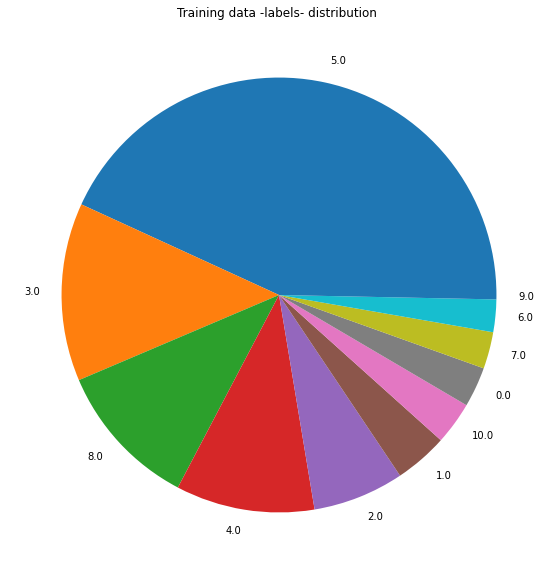

In [367]:
# plot counts of labels of training data
plt.pie(x= pd.DataFrame(y_train)[0].value_counts(), labels  = pd.DataFrame(y_train)[0].value_counts().keys() ) ;
# create plot 
plt.title("Training data -labels- distribution "); # set title for plot


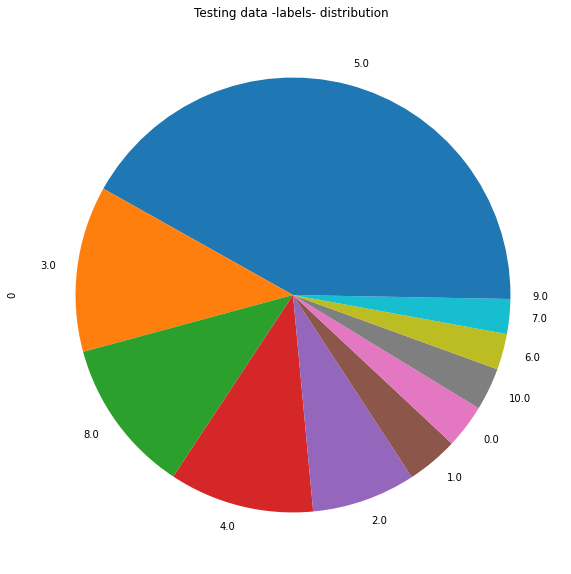

In [368]:
# plot counts of labels of testing data
ax = pd.DataFrame(y_test)[0].value_counts().plot(kind='pie') # create plot 
ax.set_title("Testing data -labels- distribution "); # set title for plot

Looks like our data is imblanced and that will affect our models results greatly one solution for that is using undersamlping or oversampling techniques , I will go with performing over-sampling using SMOTE and cleaning using ENN.in other words combine over- and under-sampling using SMOTE and Edited Nearest Neighbours. I will use implementation from imblearn library <br>
details about SMOTEENN :
https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.combine.SMOTEENN.html#imblearn.combine.SMOTEENN

In [369]:
from imblearn.combine import SMOTEENN
SMOTE_ENN = SMOTEENN(sampling_strategy = "minority")
x_train, y_train, = SMOTE_ENN.fit_sample(x_train , y_train )
x_test, y_test, = SMOTE_ENN.fit_sample(x_test , y_test )

### 1- Built in Models

In [370]:
# import LinearLearner
from sagemaker import LinearLearner

# specify an output path
prefix = 'starbucks_capstone'
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate LinearLearner
linear_starbucks = LinearLearner(role=role,
                       train_instance_count=1, 
                       train_instance_type='ml.c4.xlarge',
                       predictor_type='multiclass_classifier',
                       num_classes=11 , 
                       output_path=output_path,
                       sagemaker_session=sagemaker_session,
                       epochs=85)

In [371]:
# convert features/labels to numpy
train_x_np = x_train.astype('float32')
train_y_np = y_train.astype('float32')

# create RecordSet
train_records = linear_starbucks.record_set(train_x_np, train_y_np , channel='train')


In [372]:
#Train the model 
linear_starbucks.fit(train_records)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-09-05 00:12:54 Starting - Starting the training job...
2020-09-05 00:12:56 Starting - Launching requested ML instances......
2020-09-05 00:14:17 Starting - Preparing the instances for training.........
2020-09-05 00:15:55 Downloading - Downloading input data...
2020-09-05 00:16:22 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[09/05/2020 00:16:26 INFO 140536365401920] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'in


2020-09-05 00:16:35 Uploading - Uploading generated training model
2020-09-05 00:16:35 Completed - Training job completed
Training seconds: 40
Billable seconds: 40


In [373]:
%%time 
# deploy and create a predictor
linear_predictor = linear_starbucks.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!CPU times: user 276 ms, sys: 13.6 ms, total: 290 ms
Wall time: 7min 31s


In [374]:
def evaluate_metrics(predictor, test_features, test_labels):
    """
    Evaluate a model on a test set using the given prediction endpoint. Display classification metrics.
    """
    # split the test dataset into 100 batches and evaluate using prediction endpoint
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 100)]

    # parse protobuf responses to extract predicted labels
    extract_label = lambda x: x.label['predicted_label'].float32_tensor.values
    test_preds = np.concatenate([np.array([extract_label(x) for x in batch]) for batch in prediction_batches])
    test_preds = test_preds.reshape((-1,))
    
    return test_preds

Please note that above function was published in :
https://aws.amazon.com/blogs/machine-learning/build-multiclass-classifiers-with-amazon-sagemaker-linear-learner/

In [375]:
test_preds = evaluate_metrics(linear_predictor, x_test, y_test)# get predictions
len(test_preds) # print predictions length

1089

In [376]:
len(y_test) # print testing labels length

1089

In [379]:
# get accuracy 
from sklearn.metrics import accuracy_score
linear_acc = accuracy_score(y_test, test_preds)
print("accuracy : " , linear_acc)


# get recall 
from sklearn.metrics import recall_score
linear_rec = recall_score(y_test, test_preds, average = "weighted")
print("recall : " , linear_rec)


# get precision 
from sklearn.metrics import precision_score
linear_pre = precision_score(y_test, test_preds,average = "weighted")
print("precision_score : ",linear_pre)


# get f1 score
from sklearn.metrics import f1_score
linear_f1_score = f1_score(y_test, test_preds , average = "weighted")
print("f1_score : " , linear_f1_score)



accuracy :  0.90633608815427
recall :  0.90633608815427
precision_score :  0.8214451046907847
f1_score :  0.8618051242854186


In [444]:
performance_list= [linear_acc ,linear_rec,linear_pre ,linear_f1_score ]
performance_index = ["accuracy","recall" ,"precision_score","f1_score"] 
LL_perf_df = pd.DataFrame(performance_list , index = performance_index , columns = ["LinearLearner"])
LL_perf_df

,LinearLearner
accuracy,0.906336
recall,0.906336
precision_score,0.821445
f1_score,0.861805


In [378]:
#Delete endpoint
boto3.client('sagemaker').delete_endpoint(EndpointName=linear_predictor.endpoint)
print('Deleted {}'.format(linear_predictor.endpoint))

Deleted linear-learner-2020-09-05-00-12-54-161


### 2- Sklearn Models 

In [380]:
def make_csv(x, y, filename, data_dir,test):
    '''Merges features and labels and converts them into one csv file with labels in the first column.
       :param x: Data features
       :param y: Data labels
       :param file_name: Name of csv file, ex. 'train.csv'
       :param data_dir: The directory where files will be saved
       '''
    # make data dir, if it does not exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    # if not testing data append labels else don't append labels
    if test : 
        data = pd.concat([pd.DataFrame(y), pd.DataFrame(x)], axis=1)
        data.to_csv(os.path.join(data_dir, filename), index=False, header=False)
    else : 
        pd.DataFrame(x).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)
    

    print('Path created: '+str(data_dir)+'/'+str(filename))

The above function is from my palgarism detection project 

In [381]:
import os 
# Make csv files to upload them to s3
data_dir = 'starbucks_data'
make_csv(x_train, y_train, filename='train.csv', data_dir=data_dir , test = True)
make_csv(x_test,y_test, filename='test.csv', data_dir=data_dir,test = False)

# set prefix 
prefix = 'sagemaker/starbucks_data'

# upload all data to S3
train_loc = sagemaker_session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)
test_loc = sagemaker_session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)



Path created: starbucks_data/train.csv
Path created: starbucks_data/test.csv


In [382]:
# Create sklearn estimator 
from sagemaker.sklearn.estimator import SKLearn
Sklearn_tree = SKLearn(entry_point="train.py",
                    source_dir="Sklearn_tree",
                    role=role,
                    train_instance_count=1,
                    train_instance_type='ml.c4.xlarge')

This is not the latest supported version. If you would like to use version 0.23-1, please add framework_version=0.23-1 to your constructor.


In [383]:
# Train model
Sklearn_tree.fit({'train': train_loc })

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-09-05 00:27:01 Starting - Starting the training job...
2020-09-05 00:27:03 Starting - Launching requested ML instances......
2020-09-05 00:28:08 Starting - Preparing the instances for training...
2020-09-05 00:28:52 Downloading - Downloading input data...
2020-09-05 00:29:19 Training - Downloading the training image.2020-09-05 00:29:33,874 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2020-09-05 00:29:33,877 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-09-05 00:29:33,887 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-09-05 00:29:34,158 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-09-05 00:29:34,159 sagemaker-containers INFO     Generating setup.cfg
2020-09-05 00:29:34,159 sagemaker-containers INFO     Generating MANIFEST.in
2020-09-05 00:29:34,159 sagemaker-containers INFO     Installing module with the following comma

In [384]:
# deploy  model to create a predictor
Sklearn_tree_predictor = Sklearn_tree.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

In [385]:
# get predictions from decision tree
Sklearn_tree_preds = Sklearn_tree_predictor.predict(x_test)

In [386]:
# get accuracy 
from sklearn.metrics import accuracy_score
Sklearn_tree_acc = accuracy_score(y_test, Sklearn_tree_preds)
print("accuracy : " , Sklearn_tree_acc)


# get recall 
from sklearn.metrics import recall_score
Sklearn_tree_rec = recall_score(y_test, Sklearn_tree_preds, average = "weighted")
print("recall : " , Sklearn_tree_rec)


# get precision 
from sklearn.metrics import precision_score
Sklearn_tree_pre = precision_score(y_test, Sklearn_tree_preds, average = "weighted")
print("precision_score : ",Sklearn_tree_pre)


# get f1 score
from sklearn.metrics import f1_score
Sklearn_tree_f1_score = f1_score(y_test, Sklearn_tree_preds, average = "weighted")
print("f1_score : " , Sklearn_tree_f1_score)




accuracy :  0.7887970615243343
recall :  0.7887970615243343
precision_score :  0.8939200165058441
f1_score :  0.8252094305103993


In [446]:
performance_list= [Sklearn_tree_acc ,Sklearn_tree_rec,Sklearn_tree_pre ,Sklearn_tree_f1_score ]
performance_index = ["accuracy","recall" ,"precision_score","f1_score"] 
Desicion_tree_perf_df = pd.DataFrame(performance_list , index = performance_index , columns = ["Decision tree"])
Desicion_tree_perf_df

,Decision tree
accuracy,0.788797
recall,0.788797
precision_score,0.893920
f1_score,0.825209


In [387]:
Sklearn_tree_predictor.delete_endpoint()
# Delete endpoint

In [388]:
# create sklearn svm estimator 
Sklearn_SVM = SKLearn(entry_point="train.py",
                    source_dir="Sklearn_SVM",
                    role=role,
                    train_instance_count=1,
                    train_instance_type='ml.c4.xlarge',
                    )

This is not the latest supported version. If you would like to use version 0.23-1, please add framework_version=0.23-1 to your constructor.


In [389]:
# Train model
Sklearn_SVM.fit({'train': train_loc})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-09-05 00:40:09 Starting - Starting the training job...
2020-09-05 00:40:11 Starting - Launching requested ML instances......
2020-09-05 00:41:15 Starting - Preparing the instances for training...
2020-09-05 00:41:56 Downloading - Downloading input data...
2020-09-05 00:42:39 Training - Training image download completed. Training in progress..2020-09-05 00:42:40,431 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2020-09-05 00:42:40,434 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-09-05 00:42:40,444 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-09-05 00:42:40,723 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-09-05 00:42:40,724 sagemaker-containers INFO     Generating setup.cfg
2020-09-05 00:42:40,724 sagemaker-containers INFO     Generating MANIFEST.in
2020-09-05 00:42:40,724 sagemaker-containers INFO     Installing modul

In [390]:
# deploy  model to create a predictor
Sklearn_SVM_predictor = Sklearn_SVM.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------------!

In [391]:
# get predictions from SVM
Sklearn_SVM_preds = Sklearn_SVM_predictor.predict(x_test)

In [392]:
# get accuracy 
from sklearn.metrics import accuracy_score
Sklearn_SVM_acc = accuracy_score(y_test, Sklearn_SVM_preds )
print("accuracy : " , Sklearn_SVM_acc)


# get recall 
from sklearn.metrics import recall_score
Sklearn_SVM_rec = recall_score(y_test, Sklearn_SVM_preds, average = "weighted")
print("recall : " , Sklearn_SVM_rec)


# get precision 
from sklearn.metrics import precision_score
Sklearn_SVM_pre = precision_score(y_test, Sklearn_SVM_preds, average = "weighted")
print("precision_score : ",Sklearn_SVM_pre)


# get f1 score
from sklearn.metrics import f1_score
Sklearn_SVM_f1_score = f1_score(y_test, Sklearn_SVM_preds, average = "weighted")
print("f1_score : " , Sklearn_SVM_f1_score)






accuracy :  0.938475665748393
recall :  0.938475665748393
precision_score :  0.9368769635286799
f1_score :  0.9236890871901944


In [447]:
performance_list= [Sklearn_SVM_acc ,Sklearn_SVM_rec,Sklearn_SVM_pre ,Sklearn_SVM_f1_score ]
performance_index = ["accuracy","recall" ,"precision_score","f1_score"] 
SVC_perf_df = pd.DataFrame(performance_list , index = performance_index , columns = ["SVC"])
SVC_perf_df

,SVC
accuracy,0.938476
recall,0.938476
precision_score,0.936877
f1_score,0.923689


In [393]:
Sklearn_SVM_predictor.delete_endpoint()
# Delete endpoint

In [394]:
# create sklearn knn estimator 
Sklearn_KNN = SKLearn(entry_point="train.py",
                    source_dir="Sklearn_KNN",
                    role=role,
                    train_instance_count=1,
                    train_instance_type='ml.c4.xlarge',
                    hyperparameters={'n_neighbors' :11 })

This is not the latest supported version. If you would like to use version 0.23-1, please add framework_version=0.23-1 to your constructor.


In [395]:
# fit the model 
Sklearn_KNN.fit({'train': train_loc })

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-09-05 00:55:51 Starting - Starting the training job...
2020-09-05 00:55:53 Starting - Launching requested ML instances......
2020-09-05 00:57:00 Starting - Preparing the instances for training......
2020-09-05 00:58:17 Downloading - Downloading input data...
2020-09-05 00:58:47 Training - Downloading the training image..2020-09-05 00:59:00,800 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2020-09-05 00:59:00,803 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-09-05 00:59:00,813 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-09-05 00:59:01,087 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-09-05 00:59:01,087 sagemaker-containers INFO     Generating setup.cfg
2020-09-05 00:59:01,087 sagemaker-containers INFO     Generating MANIFEST.in
2020-09-05 00:59:01,088 sagemaker-containers INFO     Installing module with the following c

In [396]:
# deploy  model to create a predictor
Sklearn_KNN_predictor = Sklearn_KNN.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!

In [397]:
# get predictions from KNN
Sklearn_KNN_preds = Sklearn_KNN_predictor.predict(x_test)

In [398]:
# get accuracy 
from sklearn.metrics import accuracy_score
Sklearn_KNN_acc = accuracy_score(y_test, Sklearn_KNN_preds)
print("accuracy : " , Sklearn_KNN_acc)


# get recall 
from sklearn.metrics import recall_score
Sklearn_KNN_rec = recall_score(y_test, Sklearn_KNN_preds, average = "weighted")
print("recall : " , Sklearn_KNN_rec)


# get precision 
from sklearn.metrics import precision_score
Sklearn_KNN_pre = precision_score(y_test, Sklearn_KNN_preds, average = "weighted")
print("precision_score : ",Sklearn_KNN_pre)


# get f1 score
from sklearn.metrics import f1_score
Sklearn_KNN_f1_score = f1_score(y_test, Sklearn_KNN_preds, average = "weighted")
print("f1_score : " , Sklearn_KNN_f1_score)







accuracy :  0.90633608815427
recall :  0.90633608815427
precision_score :  0.9204630468433324
f1_score :  0.9111028753922215


In [449]:
performance_list= [Sklearn_KNN_acc ,Sklearn_KNN_rec,Sklearn_KNN_pre ,Sklearn_KNN_f1_score ]
performance_index = ["accuracy","recall" ,"precision_score","f1_score"] 
KNN_perf_df = pd.DataFrame(performance_list , index = performance_index , columns = ["KNN"])
KNN_perf_df

,KNN
accuracy,0.906336
recall,0.906336
precision_score,0.920463
f1_score,0.911103


In [399]:
Sklearn_KNN_predictor.delete_endpoint()
# Delete endpoint

In [400]:
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
# As stated above, we use this utility method to construct the image name for the training container.
container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The image name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance to use for training
                                    output_path='s3://{}/{}/output'.format(sagemaker_session.default_bucket(), prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=sagemaker_session) # The current SageMaker session

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [401]:
xgb.set_hyperparameters(max_depth=15,
                        eta=0.1,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='multi:softmax',
                        early_stopping_rounds=20,
                        num_round=300,
                        num_class = 11 )


In [402]:
s3_input_train = sagemaker.s3_input(s3_data=train_loc, content_type='csv')
xgb.fit({'train': s3_input_train })

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-09-05 01:08:07 Starting - Starting the training job...
2020-09-05 01:08:09 Starting - Launching requested ML instances......
2020-09-05 01:09:15 Starting - Preparing the instances for training......
2020-09-05 01:10:21 Downloading - Downloading input data...
2020-09-05 01:11:07 Training - Training image download completed. Training in progress.
2020-09-05 01:11:07 Uploading - Uploading generated training model.Arguments: train
[2020-09-05:01:11:02:INFO] Running standalone xgboost training.
[2020-09-05:01:11:02:INFO] Path /opt/ml/input/data/validation does not exist!
[2020-09-05:01:11:02:INFO] File size need to be processed in the node: 0.2mb. Available memory size in the node: 8483.96mb
[2020-09-05:01:11:02:INFO] Determined delimiter of CSV input is ','
[01:11:02] S3DistributionType set as FullyReplicated
[01:11:02] 3627x4 matrix with 14508 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[01:11:02] src/tree/updater_prune.cc:74: tree pruning end, 


2020-09-05 01:11:14 Completed - Training job completed
Training seconds: 53
Billable seconds: 53


In [403]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [404]:
xgb_transformer.transform(test_loc, content_type='text/csv', split_type='Line')

In [405]:
xgb_transformer.wait()

............................Arguments: serve
Arguments: serve
[2020-09-05 01:16:25 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-09-05 01:16:25 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-09-05 01:16:25 +0000] [1] [INFO] Using worker: gevent
[2020-09-05 01:16:25 +0000] [37] [INFO] Booting worker with pid: 37
[2020-09-05 01:16:25 +0000] [38] [INFO] Booting worker with pid: 38
[2020-09-05:01:16:25:INFO] Model loaded successfully for worker : 37
[2020-09-05:01:16:25:INFO] Model loaded successfully for worker : 38
[2020-09-05:01:16:25:INFO] Sniff delimiter as ','
[2020-09-05:01:16:25:INFO] Determined delimiter of CSV input is ','
[2020-09-05 01:16:25 +0000] [39] [INFO] Booting worker with pid: 39
[2020-09-05:01:16:25:INFO] Model loaded successfully for worker : 39
[2020-09-05 01:16:25 +0000] [40] [INFO] Booting worker with pid: 40
[2020-09-05 01:16:25 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-09-05 01:16:25 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)

In [406]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-2-823192782642/xgboost-2020-09-05-01-11-49-070/test.csv.out to starbucks_data/test.csv.out


In [407]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

In [409]:
# get accuracy 
from sklearn.metrics import accuracy_score
xgb_acc = accuracy_score(y_test, Y_pred)
print("accuracy : " , xgb_acc)


# get recall 
from sklearn.metrics import recall_score
xgb_rec = recall_score(y_test, Y_pred , average = "weighted")
print("recall : " , xgb_rec)


# get precision 
from sklearn.metrics import precision_score
xgb_pre = precision_score(y_test, Y_pred, average = "weighted")
print("precision_score : ",xgb_pre)


# get f1 score
from sklearn.metrics import f1_score
xgb_f1_score = f1_score(y_test, Y_pred, average = "weighted")
print("f1_score : " , xgb_f1_score)








accuracy :  0.8760330578512396
recall :  0.8760330578512396
precision_score :  0.9131424621165827
f1_score :  0.8886774386769841


In [450]:
performance_list= [xgb_acc ,xgb_rec,xgb_pre ,xgb_f1_score ]
performance_index = ["accuracy","recall" ,"precision_score","f1_score"] 
xgb_perf_df = pd.DataFrame(performance_list , index = performance_index , columns = ["XGBOOST"])
xgb_perf_df

,XGBOOST
accuracy,0.876033
recall,0.876033
precision_score,0.913142
f1_score,0.888677


# Models Evaluation 

In [453]:
# Get combined performace matrix 
All_perf_df = pd.concat([LL_perf_df, Desicion_tree_perf_df , SVC_perf_df , KNN_perf_df ,xgb_perf_df ] , axis =1 )

In [454]:
All_perf_df # display performance matrix 

,LinearLearner,Decision tree,SVC,KNN,XGBOOST
accuracy,0.906336,0.788797,0.938476,0.906336,0.876033
recall,0.906336,0.788797,0.938476,0.906336,0.876033
precision_score,0.821445,0.893920,0.936877,0.920463,0.913142
f1_score,0.861805,0.825209,0.923689,0.911103,0.888677


In [456]:
All_perf_df.idxmax(axis = 1) # get the best classifier in terms of
                        #accuracy - recall - precision - f1 score

accuracy           SVC
recall             SVC
precision_score    SVC
f1_score           SVC
dtype: object

In [459]:
pd.DataFrame(All_perf_df["SVC"]) 
# Show SVC as Dataframe 

,SVC
accuracy,0.938476
recall,0.938476
precision_score,0.936877
f1_score,0.923689


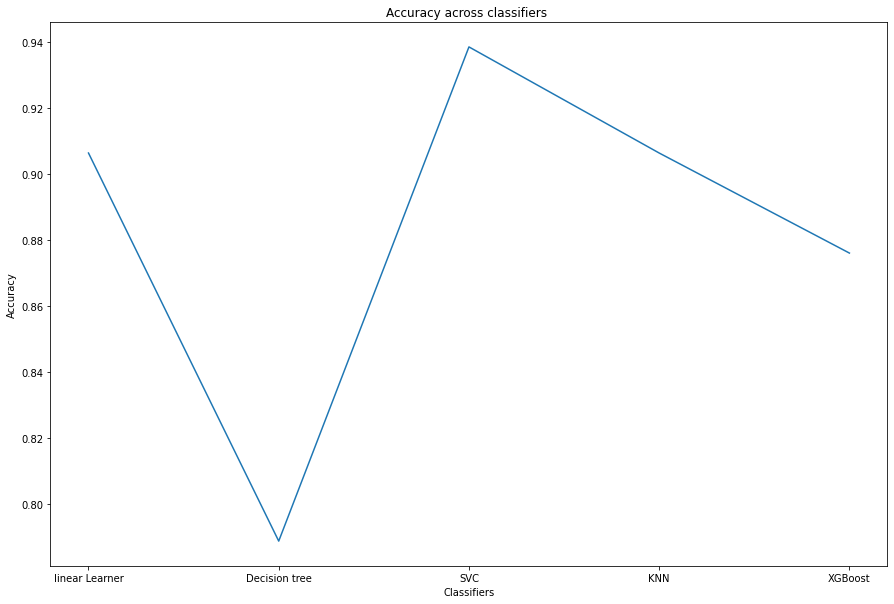

In [486]:
classifiers_accuracy = [linear_acc,Sklearn_tree_acc,Sklearn_SVM_acc,Sklearn_KNN_acc,xgb_acc]
classifiers_recall = [linear_rec,Sklearn_tree_rec,Sklearn_SVM_rec,Sklearn_KNN_rec,xgb_rec]
classifiers_precision= [linear_pre,Sklearn_tree_pre,Sklearn_SVM_pre,Sklearn_KNN_pre,xgb_pre]
classifiers_f1_score= [linear_f1_score,Sklearn_tree_f1_score,Sklearn_SVM_f1_score,Sklearn_KNN_f1_score,xgb_f1_score]
Classifiers_name = ['linear Learner','Decision tree','SVC','KNN','XGBoost']
plt.plot(Classifiers_name, classifiers_accuracy)
plt.title('Accuracy across classifiers ')
plt.ylabel('Accuracy')
plt.xlabel('Classifiers')
plt.show()

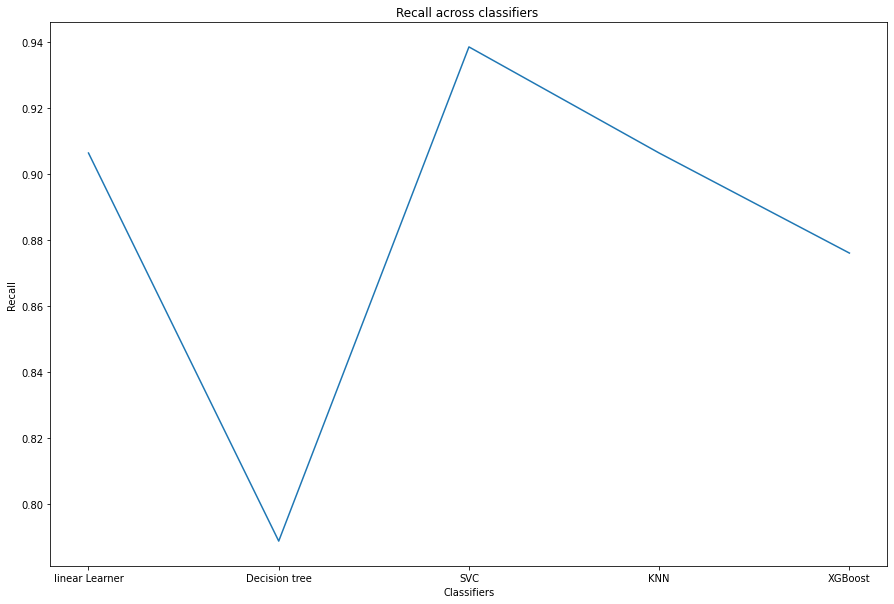

In [484]:
plt.plot(Classifiers_name, classifiers_recall)
plt.title('Recall across classifiers ')
plt.ylabel('Recall')
plt.xlabel('Classifiers')
plt.show()

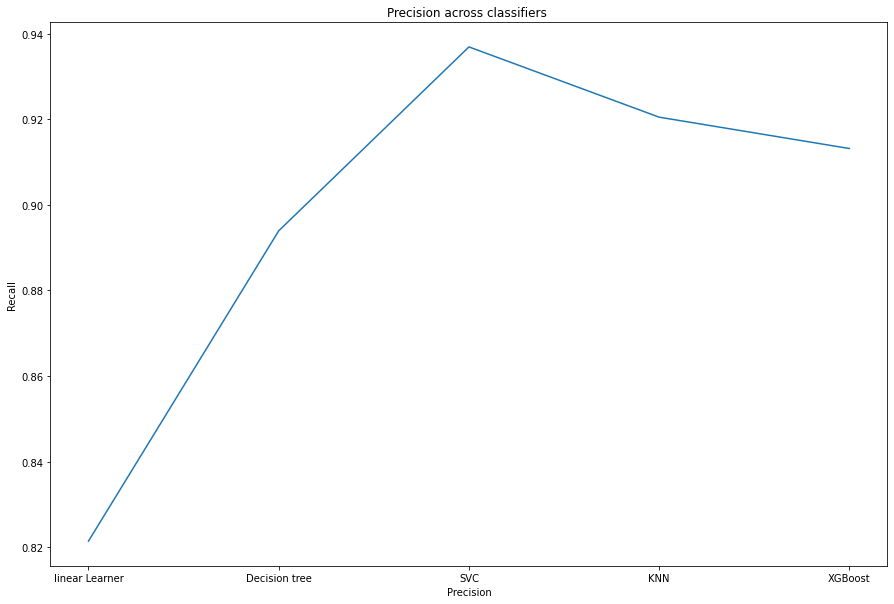

In [487]:
plt.plot(Classifiers_name, classifiers_precision)
plt.title('Precision across classifiers ')
plt.ylabel('Recall')
plt.xlabel('Precision')
plt.show()

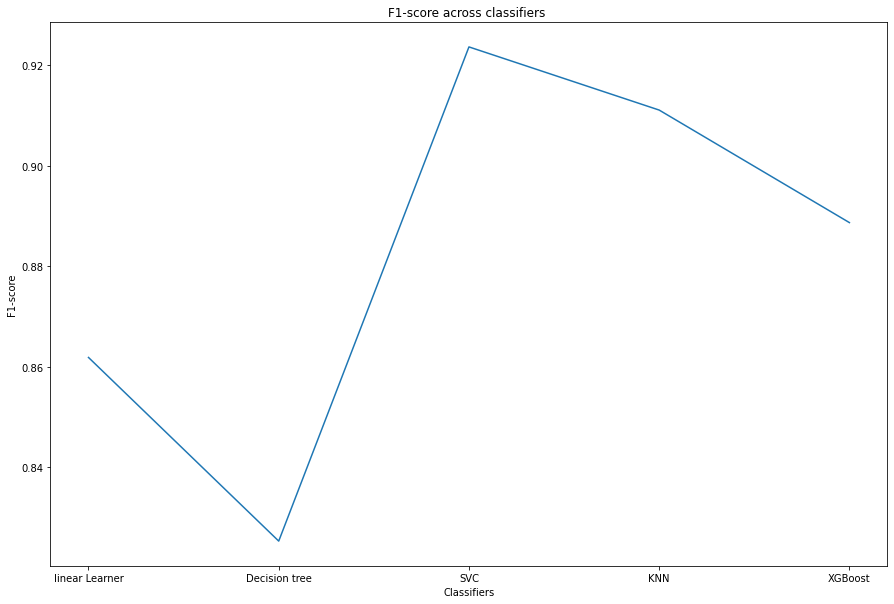

In [488]:
plt.plot(Classifiers_name, classifiers_f1_score)
plt.title('F1-score across classifiers ')
plt.ylabel('F1-score')
plt.xlabel('Classifiers')
plt.show()